# Map for BOD showing NMFS areas and locations

Author: Johanna L K Wren

Email:  johanna.wren@noaa.gov

Date:   April 19, 2021


## Description
This map is a request by Becky and the BOD to update an existing map with locations of all NMFS Science Centers, Regional Offices, and laboratories, as well as Council Management Areas and LME's. 


In [1]:
import pygmt
import geopandas as gpd
import pandas as pd
#import rasterio as rio
#import rioxarray as rxr
from pathlib import Path
import matplotlib.pyplot as plt

## Read in locations
Read in a csv file with sample locations you want to plot on the map. I used a subset version of the [sheet you sent me](https://docs.google.com/spreadsheets/d/1U3xV9l82g1hIV5LvcOzaZvO4nP2HpUurCcJLoAsgoC8/edit?usp=sharing) where I only have unique locations, and I changed all locations to be in decimal degrees. 

In [2]:
# Read in CSV file
sites = pd.read_csv('/Users/jwren/Downloads/SlickStomatopodList.csv')
# Look at data to make sure it's in the format you want it
sites

,Cruise ID,Date,Location,Station,Latitute,Longitude
0,SE1704,4/26/17,West Hawaii,Hotspot,19.36330,-155.93393
1,SE1606,9/19/16,West Hawaii,Station A,19.66500,-156.06950
2,SE1606,9/23/17,West Hawaii,Isobath,19.54175,-156.01850
3,SE1704,4/18/17,West Hawaii,E1,20.02000,-156.13000
4,SE1704,4/20/17,West Hawaii,C1,19.30000,-155.90000
...,...,...,...,...,...,...
61,SE1704,4/27/17,West Hawaii,Hotspot,19.39543,-156.12555
62,SE1704,4/29/17,West Hawaii,Control,19.38049,-156.12467
63,SE1704,4/29/17,West Hawaii,Control,19.38838,-156.11223
64,SE1704,4/24/17,West Hawaii,Control,19.36426,-155.92707


## Read in earth relief data

There are different resolutions for this that can be found [here](https://www.generic-mapping-tools.org/remote-datasets/earth-relief.html). I used the finest resolution for the figure, which is a 1 arc second resolution, but it takes a while to get the data and to plot it. If you want to play around with figures I'd use a lower resolution dataset for the testing, then switch to the high resoulution for the final figure. 

I downloaded the bathymetry for the full region, then made a hillshade grid to make the figure look more 3D. It helps with the illumination when plotting. Feel free to play around with the elevation and azimuth to see which light angle works best for your region of interest. 


In [8]:
# Get the bathymetry data
grid = pygmt.datasets.load_earth_relief(resolution="01s", region=[-161, -154, 18, 23])

# Make a hillshade grid
dgrid = pygmt.grdgradient(grid=grid, azimuth=30) #radiance=[215, 45, 's5']

Then we make a land only and ocean only grid. I'm doing this so I can have two different color palettes for them. I'm sure there is a way to make one palette in GMT using `makecpt` but I haven't figured it out in pyGMT yet so I'm doing it the cumbersome way. It used to be easy to make cpt files, but I seem to have forgotten how. 

In [4]:
# Set all points on land to Nan
gridOcean = pygmt.grdclip(grid, above=[0, 'Nan'])

# Set all points in the ocean to Nan
gridLand = pygmt.grdclip(grid, below=[0, 'Nan'])

The grid is just an xarray so it's easy to save as a netcdf and can be exported used in R or for other applications, or saved so you don't have to download it all over again. 

In [5]:
#grid.to_netcdf('bathyGrid.nc')

## Make the map

pyGMT works quite similar to GMT, but instead of the letters you use words. There is [good documentation](https://www.pygmt.org/latest/index.html) that shows the 'key' so you can easily convert a GMT script to pyGMT without too much effort. 

Start by defining your region if it's different (smaller) than the region you used to download your grid.

In [10]:
#region=[-160.5,-154.5,18.5,22.5] # Full MHI
region=[-159,-155,19,22]  # Subest a bit smaller to fit all sampling points

Then we make the map itself. PyGMT is pretty modular just like GMT and works pretty much the same way. I found it pretty easy to figure out the syntax in pyGMT

Here I'm making a map with ocean colored in blues with shading/illumination from the hillside grid we made above. This just helps make the image look more 3D, like a google map, than a flat 2D surface. Then I plot the land in a different color and shade that as well. Finally, we add the sample location points in red with a white border to make them stick out more. I have included code to add gridlines but you can toggle them on/off if you wish by commenting out that bit of code. 

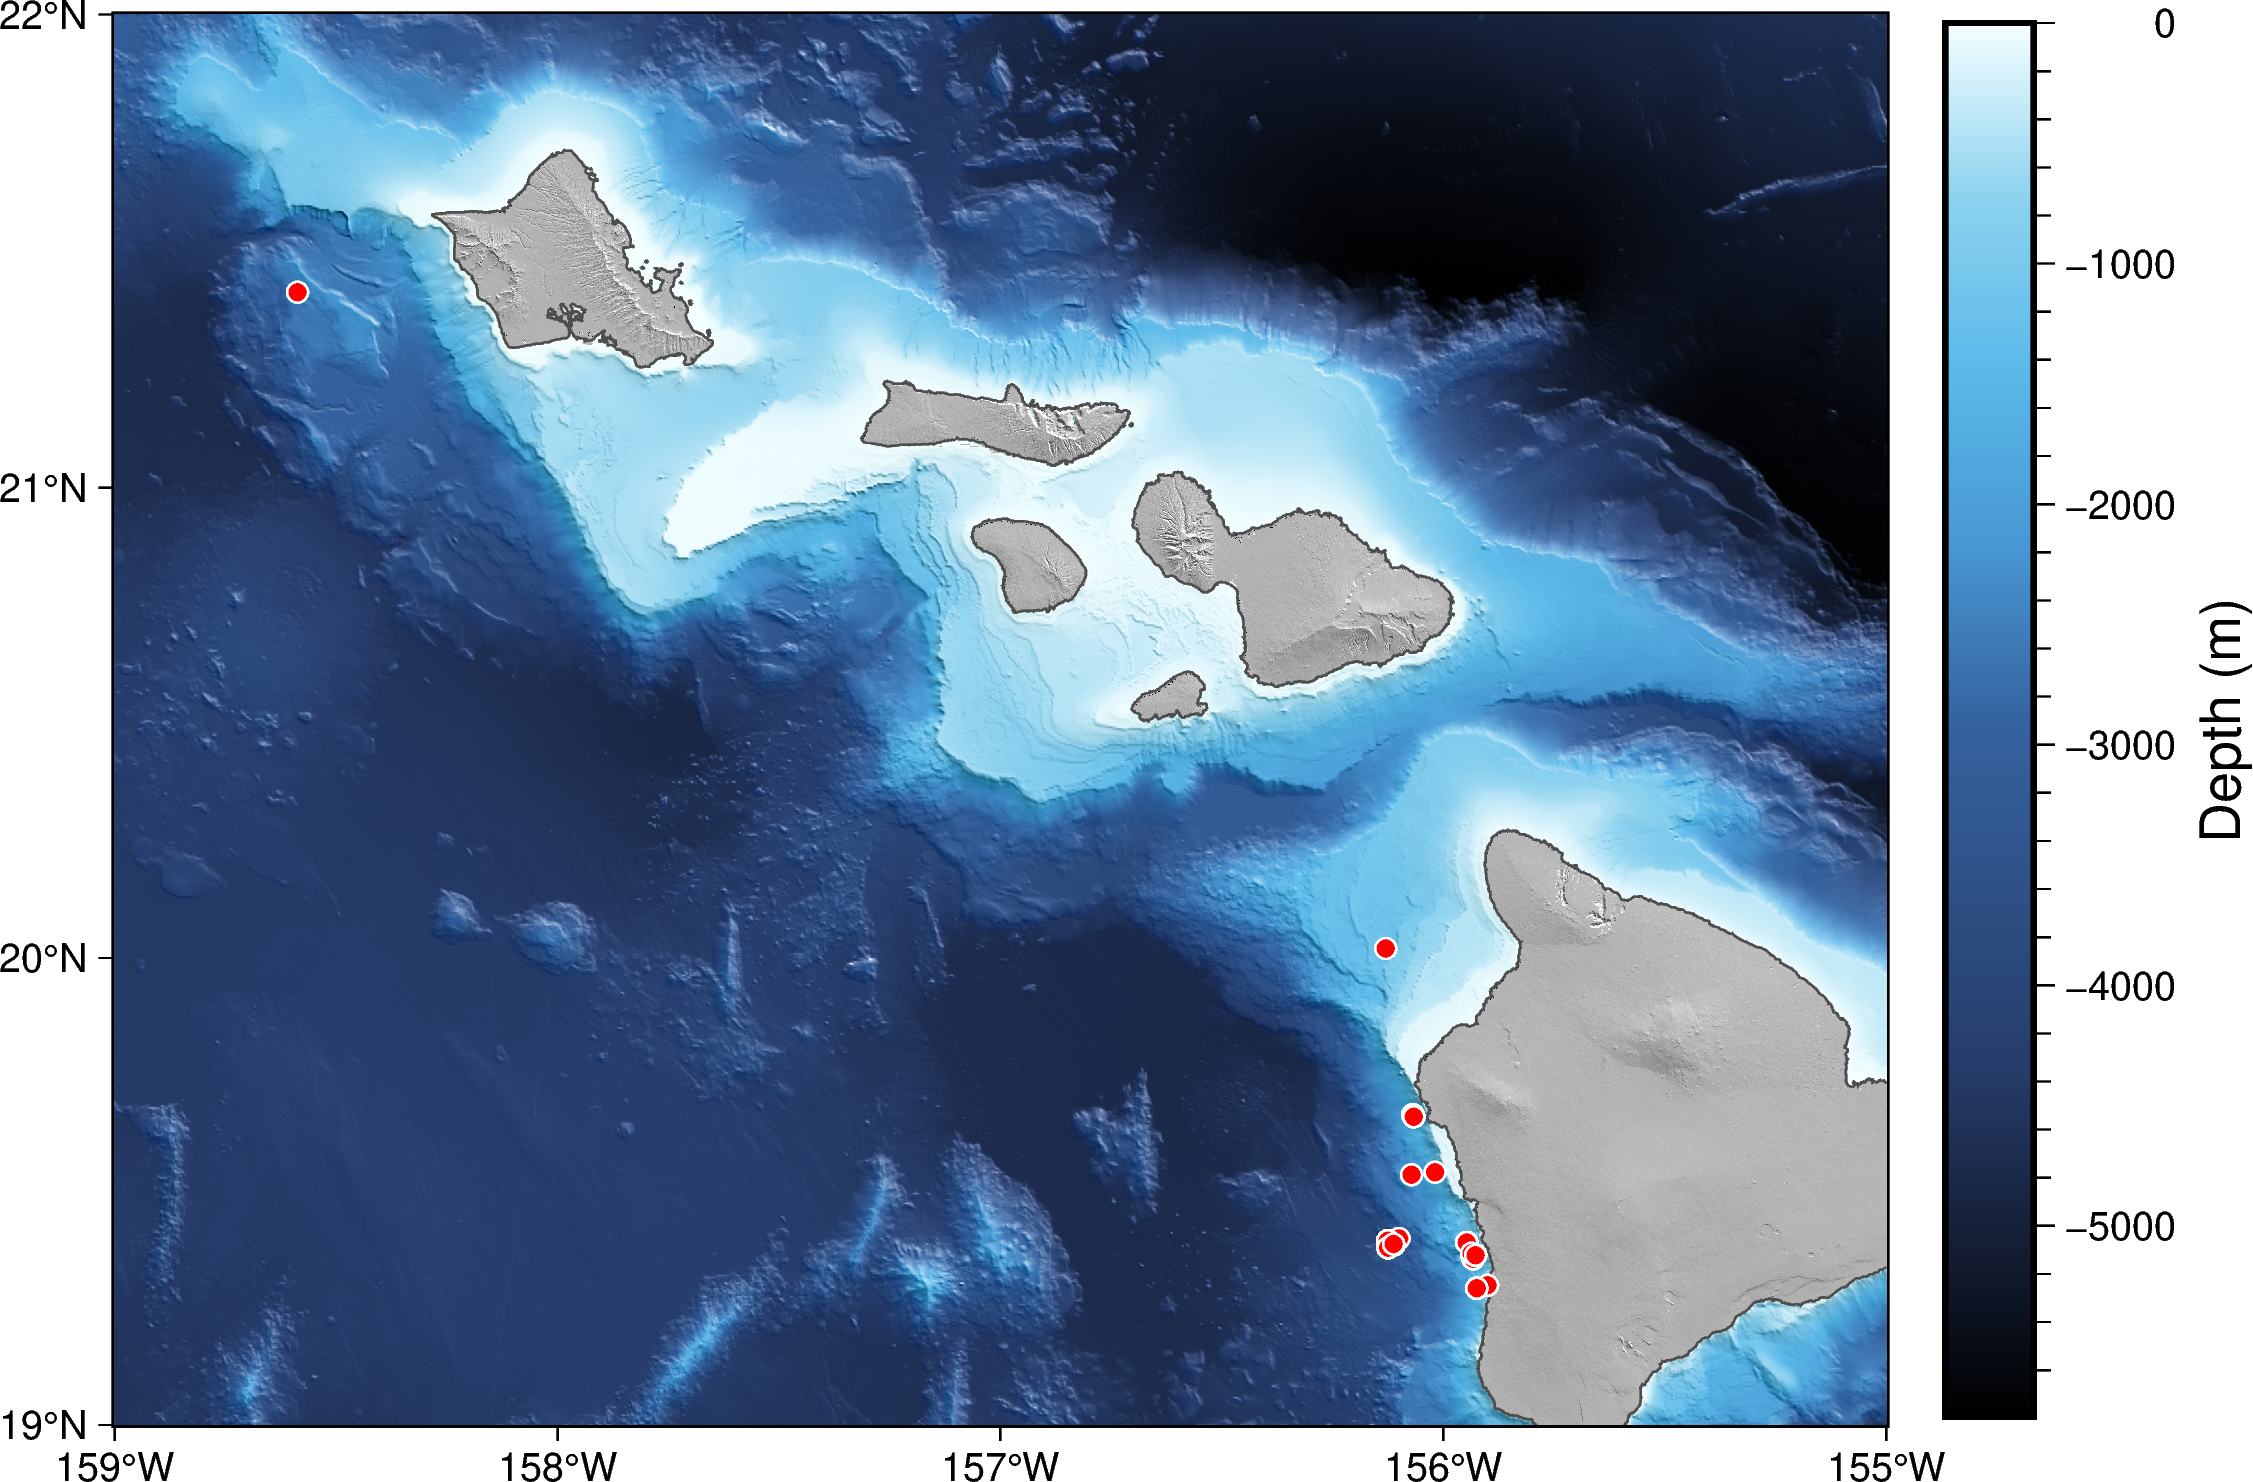

In [80]:
# Initialize the figure
fig = pygmt.Figure()
# Set GMT defaults for this plot only
with pygmt.config(MAP_FRAME_TYPE="plain"):
# Make the basemap
    fig.basemap(region=region, projection="M15c", frame='a')
# Make the grid image using bathymetry data and shade it using the hillshade grid we made above
# For ocean only
fig.grdimage(
    grid=gridOcean,
    cmap='gmt/abyss',
    shading=dgrid,
    transparency=0)
# Make colorbar
fig.colorbar(frame="x+lDepth (m)", position="JMR+o0.5c/0c+w11.8c/0.5c") 
# Make gray color palette for land
pygmt.makecpt(cmap='gray70', series=[0,4300])
# For land only
fig.grdimage(
    grid=gridLand,
    cmap=True,
    shading=dgrid,
    nan_transparent=True)
'''
# Add contours
fig.grdcontour(
    interval=1000,
    grid=grid2, pen='0.25p,gray50')
'''
# Add a coastline for a crisper look
fig.coast(resolution='f', shorelines='0.5p,gray30')
# Plot sampling stations
fig.plot(x=sites.Longitude, y=sites.Latitute, style="c5p", color="red", pen='0.5p,white')

# Display figure
fig.show()

# Save the figure
fig.savefig('/Users/jwren/Desktop/Stomatopod_map_color_zoom2.png')